In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

import argparse
import logging
from tqdm import tqdm
import numpy as np
import pandas as pd
import logging
import os
import math
import copy
import matplotlib.pyplot as plt
import optuna
from datetime import datetime
import random
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
import copy

import scipy.stats

In [2]:
import sys
sys.path.append('..')

In [3]:
from src.data.data_loader import MIMICDataset,import_data
from src.utils import setup_logger
from src.training.training_nn import *
from src.models.models import ODERNN
from src.utils import seed_everything

In [4]:
def glc_transform(x):
    x = x.copy()
    x[x > 0] = np.log(x[x > 0]) - np.log(140)
    return x

def glc_invtransform(x):
    x = x.copy()
    x = np.exp(x + np.log(140))
    return x

ginv = glc_invtransform

In [5]:
DATA_PATH = "../data/analysis.csv"
df = import_data(DATA_PATH)


excluding: 200024
excluding: 200586
excluding: 201104
excluding: 201173
excluding: 201605
excluding: 203383
excluding: 205463
excluding: 205830
excluding: 206288
excluding: 206986
excluding: 208691
excluding: 208937
excluding: 212690
excluding: 212925
excluding: 214617
excluding: 215027
excluding: 215250
excluding: 216192
excluding: 216504
excluding: 216867
excluding: 217645
excluding: 218713
excluding: 218874
excluding: 219153
excluding: 219305
excluding: 220024
excluding: 220671
excluding: 220704
excluding: 221494
excluding: 221514
excluding: 221574
excluding: 221812
excluding: 222096
excluding: 223717
excluding: 224428
excluding: 226283
excluding: 227040
excluding: 227991
excluding: 228262
excluding: 229133
excluding: 229142
excluding: 229929
excluding: 230012
excluding: 230384
excluding: 231775
excluding: 232042
excluding: 232582
excluding: 233553
excluding: 234981
excluding: 235824
excluding: 236999
excluding: 237956
excluding: 238662
excluding: 240029
excluding: 240043
excluding:

In [6]:
print(df.shape)

(318433, 97)


In [8]:
df.loc[df.icustay_id == 214619].iloc[0:20,:]

,subject_id,hadm_id,icustay_id,icu_admissiontime,icu_dischargetime,timer,timer_dt,glc,glc_dt,msk,...,demo_gender_M,demo_ethnicity_grouped_asian,demo_ethnicity_grouped_black,demo_ethnicity_grouped_hispanic,demo_ethnicity_grouped_native,demo_ethnicity_grouped_other,demo_ethnicity_grouped_unknown,demo_ethnicity_grouped_white,t0,t1
48083,87977,100011,214619,0.0,276.07,6.52,9.65,139.0,NaN,1.0,...,1,0,0,1,0,0,0,0,9.65,16.17
48084,87977,100011,214619,0.0,276.07,9.65,15.30,139.0,140.0,0.0,...,1,0,0,1,0,0,0,0,15.30,24.95
48085,87977,100011,214619,0.0,276.07,15.30,21.62,140.0,153.0,0.0,...,1,0,0,1,0,0,0,0,21.62,36.92
48086,87977,100011,214619,0.0,276.07,21.62,27.12,153.0,109.0,0.0,...,1,0,0,1,0,0,0,0,27.12,48.74
48087,87977,100011,214619,0.0,276.07,27.12,33.12,109.0,111.0,0.0,...,1,0,0,1,0,0,0,0,33.12,60.24
48088,87977,100011,214619,0.0,276.07,33.12,39.70,111.0,124.0,0.0,...,1,0,0,1,0,0,0,0,39.70,72.82
48089,87977,100011,214619,0.0,276.07,39.70,45.12,124.0,127.0,0.0,...,1,0,0,1,0,0,0,0,45.12,84.82
48090,87977,100011,214619,0.0,276.07,45.12,52.12,127.0,117.0,0.0,...,1,0,0,1,0,0,0,0,52.12,97.24
48091,87977,100011,214619,0.0,276.07,52.12,57.42,117.0,120.0,0.0,...,1,0,0,1,0,0,0,0,57.42,109.54
48092,87977,100011,214619,0.0,276.07,57.42,63.12,120.0,110.0,0.0,...,1,0,0,1,0,0,0,0,63.12,120.54


In [9]:
df['glc'] = df.groupby('icustay_id').glc.fillna(method='ffill')
df = df.loc[~df.glc.isnull()]

for id_ in df.icustay_id.unique():
    df_id = df.loc[df.icustay_id == id_,:]
    if (sum(df_id.msk) == df_id.shape[0]):
        df.drop(df.loc[df.icustay_id == id_,:].index,inplace=True)
        print("excluding:",id_)

In [10]:
from data.feature_sets import all_features

In [11]:
print(all_features())

['glc', 'input_short_injection', 'input_short_push', 'input_intermediate', 'input_long', 'input_hrs', 'demo_admission_age', 'demo_weight_first', 'demo_height_first', 'demo_diabetes_uncomplicated', 'demo_diabetes_complicated', 'elix_congestive_heart_failure', 'elix_cardiac_arrhythmias', 'elix_valvular_disease', 'elix_pulmonary_circulation', 'elix_peripheral_vascular', 'elix_hypertension', 'elix_paralysis', 'elix_other_neurological', 'elix_chronic_pulmonary', 'elix_hypothyroidism', 'elix_renal_failure', 'elix_liver_disease', 'elix_peptic_ulcer', 'elix_aids', 'elix_lymphoma', 'elix_metastatic_cancer', 'elix_solid_tumor', 'elix_rheumatoid_arthritis', 'elix_coagulopathy', 'elix_obesity', 'elix_weight_loss', 'elix_fluid_electrolyte', 'elix_blood_loss_anemia', 'elix_deficiency_anemias', 'elix_alcohol_abuse', 'elix_drug_abuse', 'elix_psychoses', 'elix_depression', 'vital_heartrate', 'vital_sysbp', 'vital_dbp', 'vital_meanbp', 'vital_resprate', 'vital_tmpc', 'vital_spo2', 'ventilated', 'med_dop

In [12]:
# df['input'] = df['input']/50
# df['input_hrs'] = df['input_hrs']/30
from sklearn.preprocessing import QuantileTransformer
from src.data.data_scaler import PreProcess

FEATURES = all_features()
NFEATURES = len(all_features())
preproc = PreProcess(FEATURES,QuantileTransformer())

train_ids, test_ids = train_test_split(df.icustay_id.unique(),test_size=0.25)

df_train = df.loc[df.icustay_id.isin(train_ids)]
df_valid = df.loc[df.icustay_id.isin(test_ids)]
preproc.fit(df_train)
df_train = preproc.transform(df_train)
df_valid = preproc.transform(df_valid)


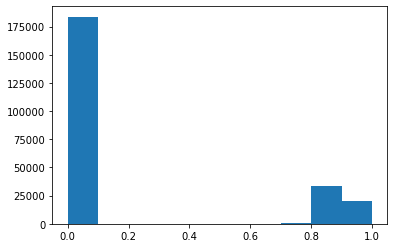

In [13]:
plt.hist(df_train['input_short_injection'])
plt.show()

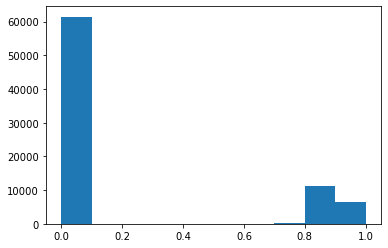

In [14]:
plt.hist(df_valid['input_short_injection'])
plt.show()

In [15]:
FEATURE_VARS = ['glc', 'input_short_injection', 'input_short_push', 'input_intermediate', 'input_long', 'input_hrs']
NFEATURES = len(FEATURE_VARS)
TIME_VARS = ["timer","timer_dt"]

class MIMICDataset(Dataset):
    """
    Args:
        patientunitstayids: 
        df:
        ...
    
    Example:
    """
    def __init__(self,df,verbose=True):
        self.X,self.y,self.msk,self.dt = self.load_data(df,verbose=verbose)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx],self.y[idx],self.msk[idx],self.dt[idx]
    
    def load_data(self,df,verbose):
        X_list, y_list, msk_list, dt_list = [], [], [], []
        ids = df.icustay_id.unique()
        if verbose:
            print("reconfiguring data...")
        for id_ in ids:
            df_id = df.loc[df.icustay_id == id_,:]
            if (sum(df_id.msk) == df_id.shape[0]):
                print("excluding:",id_)
                continue
            X = df_id.loc[:,FEATURE_VARS]
            y = df_id.loc[:,"glc_dt"]
            msk = df_id.loc[:,"msk"]
            dt = df_id.loc[:,TIME_VARS]
            X = np.array(X).astype(np.float32)
            y = np.array(y).astype(np.float32)
            msk = np.array(msk).astype(np.int32)
            dt = np.array(dt).astype(np.float32)
            X_list.append(X)
            y_list.append(y)
            msk_list.append(msk)
            dt_list.append(dt)
        return X_list,y_list,msk_list,dt_list

In [16]:
dl_train = DataLoader(MIMICDataset(df_train),batch_size=1)
dl_valid = DataLoader(MIMICDataset(df_valid),batch_size=1)
dataloaders = {'train':dl_train,'validation':dl_valid}

reconfiguring data...
reconfiguring data...


In [204]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
#from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import math

# Base ----------------------------------------------------------------------------

import torch.nn.functional as F

class Baseline(nn.Module):
    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        super(Baseline, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.p = p
        self.device = device
        
    def train_single_epoch(self,dataloader,optim):
        loss = 0.0
        for i, (x, y, msk, dt) in enumerate(dataloader):
            x = x.to(self.device)
            y = y.view(-1,1).to(self.device)
            dt = dt.to(self.device)
            msk = msk.bool().to(self.device)
            optim.zero_grad()
            preds = self.forward(dt,x)
            loss_step = self.loss_fn(preds,y,~msk.squeeze(0))
            loss_step.backward()
            #torch.nn.utils.clip_grad_norm_(self.parameters(), 10.0)
            optim.step()
            loss += loss_step.item()
            if i % 1e3 == 0:
                print("BATCH_loss : {:05.3f}".format(loss_step.item()))
        loss /= (i + 1)
        print("EPOCH_loss : {:05.3f}".format(loss))
        
        return loss
        
    def evaluate(self,dataloader,p=0.0):
        rmse, loss = 0., 0.
        N = 0
        y_preds = []
        y_tests = []
        msks = []
        #dts = []
        with tqdm(total=len(dataloader)) as t:
            for i, (x, y, msk, dt) in enumerate(dataloader):
                N += sum((msk == 0).squeeze(0)).item()
                x = x.to(self.device)
                y = y.view(-1,1).to(self.device)
                dt = dt.to(self.device)
                # model prediction
                y_ = self.forward(dt,x)
                y_preds.append([yc.detach().cpu().numpy() for yc in y_]) 
                y_tests.append(y.cpu().numpy())
                msk = msk.bool().to(self.device)
                rmse += self.get_sse(y_,y,~msk.squeeze(0)).item()
                loss += self.loss_fn(y_,y,~msk.squeeze(0)).item()
                msks.append(msk.cpu().numpy())
                t.update()
        rmse /= N
        loss /= (i + 1)
        rmse = math.sqrt(rmse)
        print("_rmse : {:05.3f}".format(rmse))
        print("_loss : {:05.3f}".format(loss))
        return loss,rmse, y_preds, y_tests, msks

    def get_sse(self,y_,y,msk):
        """
        SSE: sum of squared errors
        """
        if type(y_) == tuple:
            y_ = y_[0]
        c = torch.log(torch.tensor(140.0))
        rmse = torch.sum((torch.exp(y_[msk] + c) - torch.exp(y[msk] + c))**2)
        return rmse

In [ ]:
    
# class ODEFunc(nn.Module):
#     """
#     dglucose/dt = NN(glucose,insulin)
#     """
#     def __init__(self,input_dim,hidden_dim):
#         super(ODEFunc, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(hidden_dim, 50),
#             nn.Tanh(),
#             nn.Linear(50, hidden_dim),
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, z):
#         return self.net(z)

# class LatentODE1(Baseline):

#     def __init__(self, input_dim, hidden_dim, p, output_dim, device):
#         Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
#         self.device = device
#         self.encoder = nn.LSTMCell(input_dim,hidden_dim)
#         self.func = ODEFunc(input_dim,hidden_dim).to(device)
#         self.sigma = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1),
#             nn.Softplus()
#         )
#         self.mu = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1)
#         )

#     def forward(self, dt, x):
        
        
#         x = x.squeeze(0)
#         dt = dt.squeeze(0)
#         T = x.size(0)
        
#         mu_out,sigma_out = torch.zeros(T,1,device = self.device),torch.zeros(T,1,device = self.device) 
#         #z_t = torch.zeros(1,self.hidden_dim,device = self.device)
#         z_1 = torch.zeros(1,self.hidden_dim,device = self.device)
#         c_1 = torch.zeros(1,self.hidden_dim,device = self.device)
#         for i in range(0,T):
#             # encode 
#             z_1,c_1 = self.encoder(x[i].unsqueeze(0),(z_1.detach().clone(),c_1.detach().clone()))
            
#             # ODE
#             z_2 = self.euler(self.func,z_1,dt[i],1.0)
            
#             # decode 
#             sigma = self.sigma(z_2)
#             mu = self.mu(z_2)
#             sigma_out[i] = sigma
#             mu_out[i] = mu
        
#         return (mu_out,sigma_out)
    
#     def loss_fn(self,mu_s_,y,msk):
#         y_, s_ = mu_s_
#         distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
#         likelihood = distribution.log_prob(y[msk])
#         return -torch.mean(likelihood)
    
#     def euler(self,func,z0,t,h):
#         if (t[1]-t[0]) == 0:
#             return z0
#         else:
#             tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
#             hs = torch.diff(tsteps)
#             #y = copy.deepcopy(y0)
#             z = z0.detach().clone()
#             for h in hs:
#                 z += h*func(z.detach().clone())
#         return z 



In [ ]:
    
# class ODEFunc(nn.Module):
#     """
#     dglucose/dt = NN(glucose,insulin)
#     """
#     def __init__(self,input_dim,hidden_dim):
#         super(ODEFunc, self).__init__()

#         self.net = nn.Sequential(
#             nn.Linear(input_dim+hidden_dim, 50),
#             nn.Tanh(),
#             nn.Linear(50, hidden_dim),
#         )

#         for m in self.net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)

#     def forward(self, z, x=None):
#         if x != None:
#             zx = torch.cat((z,x),1)
#         else:
#             zx = z
#         return self.net(zx)
    
# class LatentODE2(Baseline):

#     def __init__(self, input_dim, hidden_dim, p, output_dim, device):
#         Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
#         self.device = device
#         self.func = ODEFunc(input_dim,hidden_dim).to(device)
#         self.dfunc = ODEFunc(0,hidden_dim).to(device)
#         self.sigma = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.Tanh(),
#             nn.Linear(hidden_dim, 1),
#             nn.Softplus()
#         )
#         self.mu = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.Tanh(),
#             nn.Linear(hidden_dim, 1)
#         )

#     def forward(self, dt, x):
        
        
#         x = x.squeeze(0)
#         dt = dt.squeeze(0)
#         T = x.size(0)
        
#         mu_out,sigma_out= torch.zeros(T,1,device = self.device),torch.zeros(T,1,device = self.device) 
#         z_t = torch.zeros(1,self.hidden_dim,device = self.device)
#         for i in range(0,T):
#             # update hidden state
#             z_t = self.euler1(self.dfunc,z_t.clone(),dt[i],h=1.0)
            
#             # encode ODE
#             x_i = x[i].unsqueeze(0)
#             z_t = self.euler(self.func,z_t.clone(),x_i,dt[i],h=1.0)
            
#             # decode 
#             sigma = self.sigma(z_t.clone())
#             mu = self.mu(z_t.clone())
#             sigma_out[i] = sigma
#             mu_out[i] = mu
        
#         return (mu_out,sigma_out)
    
#     def loss_fn(self,mu_s_,y,msk):
#         y_, s_ = mu_s_
#         distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
#         likelihood = distribution.log_prob(y[msk])
#         return -torch.mean(likelihood)

#     def euler(self,func,y0,x,t,h):
#         if (t[1]-t[0]) == 0:
#             return y0
#         else :
#             tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
#             hs = torch.diff(tsteps)
#             #y = copy.deepcopy(y0)
#             y = y0
#             for h in hs:
#                 y += h*func(y,x)
#         return y 

#     def euler1(self,func,y0,t,h):
#         if (t[1]-t[0]) == 0:
#             return y0
#         else :
#             tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
#             hs = torch.diff(tsteps)
#             #y = copy.deepcopy(y0)
#             y = y0.detach().clone()
#             for h in hs:
#                 y += h*func(y.detach().clone())
#         return y 


In [205]:
    
class ODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,input_dim,hidden_dim):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_dim),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, z, x):
        zx = torch.cat((z,x),1)
        return self.net(zx)
    
class LatentODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = ODEFunc(input_dim,hidden_dim).to(device)
        self.sigma = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        )
        self.mu = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, dt, x):
        
        
        x = x.squeeze(0)
        dt = dt.squeeze(0)
        T = x.size(0)
        
        mu_out,sigma_out= torch.zeros(T,1,device = self.device),torch.zeros(T,1,device = self.device) 
        z_t = torch.zeros(1,self.hidden_dim,device = self.device)
        for i in range(0,T):
            
            # embedding layer
            # ....
            
            # encode - ODE
            x_i = x[i].unsqueeze(0)
            z_t = self.euler(self.func,z_t.clone(),x_i,dt[i],h=1.0)
            
            # output layer 
            sigma = self.sigma(z_t.clone())
            mu = self.mu(z_t.clone())
            sigma_out[i] = sigma
            mu_out[i] = mu
        
        return (mu_out,sigma_out)
    
    def loss_fn(self,mu_s_,y,msk):
        y_, s_ = mu_s_
        distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk])
        return -torch.mean(likelihood)

    def euler(self,func,y0,x,t,h):
        if (t[1]-t[0]) == 0:
            return y0
        else :
            tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
            hs = torch.diff(tsteps)
            #y = copy.deepcopy(y0)
            y = y0
            for h in hs:
                y += h*func(y,x)
        return y 

In [213]:
class LODEFunc(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,hidden_dim,input_dim,device):
        super(LODEFunc, self).__init__()

        self.x = torch.zeros(128,100,input_dim).to(device)
        self.dt = torch.zeros(128,100,1).to(device)
        self.device = device
        self.net = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_dim),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, z):
        xz = torch.cat((z,self.x),1)
        out = self.net(xz)
        out = out * (self.dt/24) # -> scale by timestep
        return out 

    def solve_ode(self, z0, t, x):
        self.x = x  # overwrites
        self.dt = t
#         t24 = t.item()/24
#         outputs = odeint(self, z0, torch.tensor([0,t24]).to(self.device),method="euler",options=dict(step_size=max(0.1,t24/4)))[1]
        #t24 = t.item()/24
        outputs = odeint(self, z0, torch.tensor([0.,1.]).to(self.device),method="euler",options=dict(step_size=0.25))[1]
        return outputs
    
    def euler(self,func,y0,t,h):
        if (t[1]-t[0]) == 0:
            return y0
        else :
            
            tsteps = torch.linspace(t[0],t[1],int(2+(t[1]-t[0]) // h))
            hs = torch.diff(tsteps)
            #y = copy.deepcopy(y0)
            y = y0
            for h in hs:
                y += h*self(0,y)
        return y 

class latentODE(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = LODEFunc(hidden_dim,input_dim,device).to(device)
        self.mu_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        ).to(device)
        self.sigma_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus()
        ).to(device)
        self.encode_z0 = nn.Sequential(
            nn.Linear(input_dim, max(hidden_dim,hidden_dim) // 2),
            nn.Tanh(),
            nn.Linear(max(hidden_dim,hidden_dim) // 2, hidden_dim),
            nn.Tanh(),
        ).to(device)
        
#         for m in self.encode_z0.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, mean=0, std=0.1)
#                 nn.init.constant_(m.bias, val=0)
        
    def forward(self, dt, x):
        
        x = x.squeeze(0)
        dt = dt.squeeze(0)
        T = x.shape[0]
                
        mu_out,s_out= torch.zeros(T,1,device = self.device),torch.zeros(T,1,device = self.device) 
        z_t = torch.zeros(1,self.hidden_dim,device = self.device)
        
        for i in range(0,T):
            x_i = x[i:(i+1),:]
            dt_i = (dt[i][1] - dt[i][0])
            if dt_i.item() > 0:
                z_t = self.func.solve_ode(z_t.clone(),dt_i,x_i)
            else:
                z_t = z_t
            mu_out[i] = self.mu_net(z_t)
            s_out[i] = self.sigma_net(z_t)

        return (mu_out,s_out)
    
    def loss_fn(self,mu_s_,y,msk):
        y_, s_ = mu_s_
        distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk])
        return -torch.mean(likelihood)

    
#     def loss_fn(self,y_,y,msk):
#         return sum((y_[msk] - y[msk])**2)

In [214]:
model = latentODE(NFEATURES, 8, 0.5, 1, "cpu").to("cpu")

In [208]:
NFEATURES

6

In [209]:
t = next(iter(dl_train))[3].squeeze(0).to("cpu")
x = next(iter(dl_train))[0].squeeze(0).to("cpu")
y = next(iter(dl_train))[1].squeeze(0)
msk = next(iter(dl_train))[2].squeeze(0).to("cpu")
y_ = model(t,x)
model.loss_fn(y_,y.to("cpu"),~msk.bool())
print(y_)
print(y_[1])
print(y_[0].shape)
print(y_[1].shape)

(tensor([[-0.1324],
        [-0.1268],
        [-0.1266],
        [-0.1237],
        [-0.1230],
        [-0.1181],
        [-0.1154]], grad_fn=<CopySlices>), tensor([[0.7812],
        [0.7797],
        [0.7790],
        [0.7778],
        [0.7771],
        [0.7747],
        [0.7731]], grad_fn=<CopySlices>))
tensor([[0.7812],
        [0.7797],
        [0.7790],
        [0.7778],
        [0.7771],
        [0.7747],
        [0.7731]], grad_fn=<CopySlices>)
torch.Size([7, 1])
torch.Size([7, 1])


In [215]:
model_optim = optim.RMSprop(model.parameters(), lr=1e-3)
# BATCH_loss : 0.700
# BATCH_loss : -0.327
# BATCH_loss : -0.240
# BATCH_loss : -0.239
# BATCH_loss : -0.118
# BATCH_loss : 0.011
# BATCH_loss : 0.465
# BATCH_loss : -0.378
# BATCH_loss : -0.289
# BATCH_loss : -0.422

# BATCH_loss : 0.674
# BATCH_loss : -0.411
# BATCH_loss : -0.156
# BATCH_loss : 0.130
# BATCH_loss : -0.041
# BATCH_loss : 0.076
# BATCH_loss : 1.250
# BATCH_loss : -0.286
# BATCH_loss : -0.134
# BATCH_loss : -0.398
# BATCH_loss : 0.553
# BATCH_loss : -0.048
# BATCH_loss : 0.284
# EPOCH_loss : 0.149

In [216]:
model.train_single_epoch(dl_train,model_optim)

BATCH_loss : 0.975
BATCH_loss : -0.366
BATCH_loss : -0.100
BATCH_loss : -0.029
BATCH_loss : -0.045
BATCH_loss : 0.008
BATCH_loss : 1.353
BATCH_loss : -0.310
BATCH_loss : -0.182
BATCH_loss : -0.371
BATCH_loss : 0.523
BATCH_loss : -0.079
BATCH_loss : 0.159
EPOCH_loss : 0.127


0.12707904078092686

In [217]:
loss,rmse, y_preds, y_tests, msks = model.evaluate(dl_valid)

100%|██████████| 4123/4123 [01:08<00:00, 60.25it/s] 

_rmse : 43.624
_loss : 0.068


In [192]:
rmse
# _rmse : 48.872
# _loss : 0.123

41.27153708799015

In [ ]:
plt.scatter(df_valid.glc,df_valid.glc_dt)

In [ ]:
df_valid["glc_dt_locf"] = df_valid.glc
df_valid.loc[df_valid.glc_dt_locf == 0,'glc_dt_locf'] = np.NaN
df_valid["glc_dt_locf"] = df_valid.groupby('icustay_id')["glc_dt_locf"].ffill()
res_rmse_locf = math.sqrt(np.mean((ginv(df_valid.glc_dt_locf[df_valid.msk==0]) - ginv(df_valid.glc_dt[df_valid.msk==0]))**2))
print("RMSE (locf): {:05.4f}".format(res_rmse_locf))

In [ ]:
math.sqrt(np.mean((df_valid.glc[df_valid.msk==0] - df_valid.glc_dt[df_valid.msk==0])**2))

In [ ]:
rmse / res_rmse_locf

In [ ]:
mu_preds = [y[0] for y in y_preds]
s_preds = [y[1] for y in y_preds]

In [ ]:
mu_preds = np.concatenate(mu_preds)
y_tests = np.concatenate(y_tests)

In [ ]:
s_preds = np.concatenate(s_preds)

In [ ]:
df_valid['mu_preds'] = mu_preds
df_valid['s_preds'] = s_preds

In [ ]:
dts = np.linspace(0,11,12)
dts = np.append(dts,12.)
for i in range(dts.shape[0]-1):
    print('time ahead (hours): {:05.2f}-{:05.2f}'.format(dts[i],dts[i+1]))
    msk = (df_valid.msk==0) & (df_valid.dt >= dts[i]) & (df_valid.dt < dts[i+1])
    print("N: {:5}".format(sum(msk)))
    res_rmse_locf = math.sqrt(np.mean((ginv(df_valid.glc_dt_locf[msk]) - ginv(df_valid.glc_dt[msk]))**2))
    print("RMSE (locf): {:05.4f}".format(res_rmse_locf))
    res_rmse_model = math.sqrt(np.mean((ginv(df_valid.mu_preds[msk]) - ginv(df_valid.glc_dt[msk]))**2))
    print("RMSE (model): {:05.4f}".format(res_rmse_model))
    print("{:05.4f}".format(res_rmse_model/res_rmse_locf))

In [ ]:
ids = df_valid.icustay_id.unique()
id_ = random.sample(list(ids),1)
print(id_)
df_i = df_valid.loc[(df_valid.icustay_id == id_[0])]
plt.scatter(df_i.t1,df_i.glc_dt)
plt.plot(df_i.t1[df_i.msk == 0],df_i.mu_preds[df_i.msk == 0],'-r')
plt.plot(df_i.t1[df_i.msk == 0],df_i.mu_preds[df_i.msk == 0] + 2*df_i.s_preds[df_i.msk == 0],'--r')
plt.plot(df_i.t1[df_i.msk == 0],df_i.mu_preds[df_i.msk == 0] - 2*df_i.s_preds[df_i.msk == 0],'--r')

In [ ]:
msks = np.concatenate([msk[0] for msk in msks])

In [ ]:
prob_test = scipy.stats.norm(mu_preds[~msks].reshape(-1,1), s_preds[~msks].reshape(-1,1)).cdf(y_tests[~msks])

In [ ]:
plt.hist(prob_test)

In [ ]:
print("variance of probabilities:")
np.var(prob_test)

In [ ]:
plt.scatter(mu_preds[msks],y_tests[msks])
xs = np.linspace(-1.5,1.5)
plt.plot(xs,xs,'--r')

In [ ]:
t = next(iter(dl_train))[3].squeeze(0).to("cuda")
x = next(iter(dl_train))[0].squeeze(0).to("cuda")
y = next(iter(dl_train))[1].squeeze(0)
msk = next(iter(dl_train))[2].squeeze(0)
y_ = model(t,x)

In [ ]:
# FEATURE_VARS = ["injection","input_hrs","input","glc"]

In [ ]:
xx = torch.tensor([[0.0000,  0.0000, 0.000, 0.3412],
        [ 0.0000,  0.0000,  0.0000, 0.2412]], device='cuda:0')
print(ginv(xx[:,3].cpu().numpy()))
tt = torch.tensor([[0.0081, 1.0081],
        [3.0081, 3.4081]], device='cuda:0')
ys = model(tt,xx)
ginv(ys[0].detach().cpu().numpy())

In [ ]:
ys = model(tt,xx)

In [ ]:
ginv(ys[0].detach().cpu().numpy())

In [ ]:
sum((df_train.injection > 0) & (df_train.input > 0))

In [ ]:
plt.hist(s_preds[s_preds<1.0],bins=20)

In [ ]:
# cut out dimension 1

In [ ]:
class LatentODE1_(nn.Module):
    """
    dglucose/dt = NN(glucose,insulin)
    """
    def __init__(self,hidden_dim,input_dim,batch_size,device):
        super(LatentODE1_, self).__init__()
        
        self.x = torch.zeros(batch_size,SEQUENCE_LENGTH,input_dim).to(device)
        self.dt = torch.zeros(batch_size,SEQUENCE_LENGTH,1).to(device)
        self.device = device
        self.net = nn.Sequential(
            nn.Linear(input_dim+hidden_dim, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_dim),
            nn.Tanh(),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, z):
        xz = torch.cat((z,self.x),1)
        return self.net(xz)*(self.dt*DT_SCALER) # -> scale by timestep
    
    def solve_ode(self, z0, t, x):
        self.x = x  # overwrites
        self.dt = t
        outputs = odeint(self, z0, torch.tensor([0,1.0]).to(self.device),method='euler',options=dict(step_size=0.25))[1]
        return outputs
    
class LatentODE1(Baseline):

    def __init__(self, input_dim, hidden_dim, p, output_dim, batch_size,device):
        Baseline.__init__(self,input_dim, hidden_dim, p, output_dim, device)
        self.device = device
        self.func = LatentODE1_(hidden_dim,input_dim,batch_size,device).to(device)
        self.mu_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        ).to(device)
        self.sigma_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1),
            nn.Softplus(),
        ).to(device)
        self.encode_z0 = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.Tanh(),
            nn.Linear(10, hidden_dim),
            nn.Tanh(),
        ).to(device)
        
        for m in self.encode_z0.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)
        
    def forward(self, dt, x, p=0.0):
        
        #x = x.squeeze(0)
        batch_size = x.size(0)
        T = x.size(1)
        
        # ODE
        mu_out = torch.zeros(batch_size,T,1,device = self.device)
        sigma_out = torch.zeros(batch_size,T,1,device = self.device)
        #z0 = 0.01 * torch.randn(batch_size,1,self.hidden_dim,device = self.device)
        #z0 = self.encode_z0(x[:,0,:]).unsqueeze(1)
        z0 = torch.zeros(batch_size,self.hidden_dim,device = self.device)
        for i in range(0,T):
            x_i = x[:,i,:]
            dt_i = (dt[:,i,:][:,1] - dt[:,i,:][:,0]).unsqueeze(1).unsqueeze(1)
            z0 = self.func.solve_ode(z0.clone(),dt_i,x_i)
            mu_out[:,i:(i+1),:] = self.mu_net(z0.squeeze(1)).unsqueeze(1)
            sigma_out[:,i:(i+1),:] = self.sigma_net(z0.squeeze(1)).unsqueeze(1)
            
        return mu_out,sigma_out
    
    def loss_fn(self,mu_s_,y,msk):
        y_, s_ = mu_s_
        distribution = torch.distributions.normal.Normal(y_[msk], s_[msk])
        likelihood = distribution.log_prob(y[msk])
        return -torch.mean(likelihood)